We want block ids

We want to use the census for its hierarchical nature, and pairing with the detroit data set

Detroit uses 2010 and 2020 versions of census blocks

options [here](https://data.census.gov/cedsci/table?q=Population%20Total&t=Counts,%20Estimates,%20and%20Projections&g=0500000US26163%241000000)


* P1 from the decennial census breaks down by race (obviously get totals from there)
* P2 is just hispanic/latino or not
* H10 gives us population data by housing, with subsets thereof giving more slices
* P12 sex and age

# Read in several sources, check counts and consistency

In [67]:
decennial_p10 = (
    pd.read_csv(
        "/Users/ahakso/Downloads/productDownload_2022-01-28T162855/DECENNIALSF12010.P10_data_with_overlays_2022-01-28T162836.csv",
        usecols=["GEO_ID", "P010001", "NAME"],
        skiprows=[1],
    )
    .rename(columns={"GEO_ID": "block_id", "P010001": "population"})
    .assign(block_id=lambda x: x.block_id.str.split("US").apply(lambda s: s[1]))
    .astype({"block_id": float})
)
# pop = pop
print(decennial_p10.shape)
(decennial_p10.head(2))

(13913, 3)


,block_id,population,NAME
0,2.616350e+14,44,"Block 1012, Block Group 1, Census Tract 5001, ..."
1,2.616350e+14,57,"Block 1013, Block Group 1, Census Tract 5001, ..."


In [8]:
cols = {"GEO_ID": "block_id", "P1_001N": "population"}
decennial_p1_2020 = (
    pd.read_csv(
        "population/DECENNIALPL2020.P1_data_with_overlays_2022-02-06T092022.csv",
        usecols=cols.keys(),
        skiprows=[1],
    )
    .rename(columns=cols)
    .assign(block_id=lambda x: x.block_id.str.split("US").apply(lambda s: s[1]))
)
print(decennial_p1_2020.shape)
(decennial_p1_2020.head(2))

(32022, 2)


,block_id,population
0,261635001001000,14
1,261635001001001,100


In [68]:
decennial_p1_2010 = (
    pd.read_csv(
        "/Users/ahakso/Downloads/productDownload_2022-02-06T092039/DECENNIALPL2010.P1_data_with_overlays_2022-02-06T092022.csv",
        usecols=["GEO_ID", "P001001", "NAME"],
        skiprows=[1],
    )
    .rename(columns={"GEO_ID": "block_id", "P001001": "population"})
    .assign(block_id=lambda x: x.block_id.str.split("US").apply(lambda s: s[1]))
    .astype({"block_id": float})
)
print(decennial_p1_2010.shape)
(decennial_p1_2010.head(2))

(13913, 3)


,block_id,population,NAME
0,2.616350e+14,68,"Block 1012, Block Group 1, Census Tract 5001, ..."
1,2.616350e+14,98,"Block 1013, Block Group 1, Census Tract 5001, ..."


In [71]:
t = pd.merge(decennial_p1_2020,decennial_p1_2010,on='block_id',how='outer',indicator=True)
t._merge.value_counts()

left_only     26466
right_only     8357
both           5556
Name: _merge, dtype: int64

In [74]:
tt = t.query("_merge == 'both' ")
print(tt.NAME_x.iloc[0])
print(tt.NAME_y.iloc[0])

Block 1012, Block Group 1, Census Tract 5001, Wayne County, Michigan
Block 1012, Block Group 1, Census Tract 5001, Wayne County, Michigan


# Look at grain impact on zeros

Proportion 0 population: 0.1869


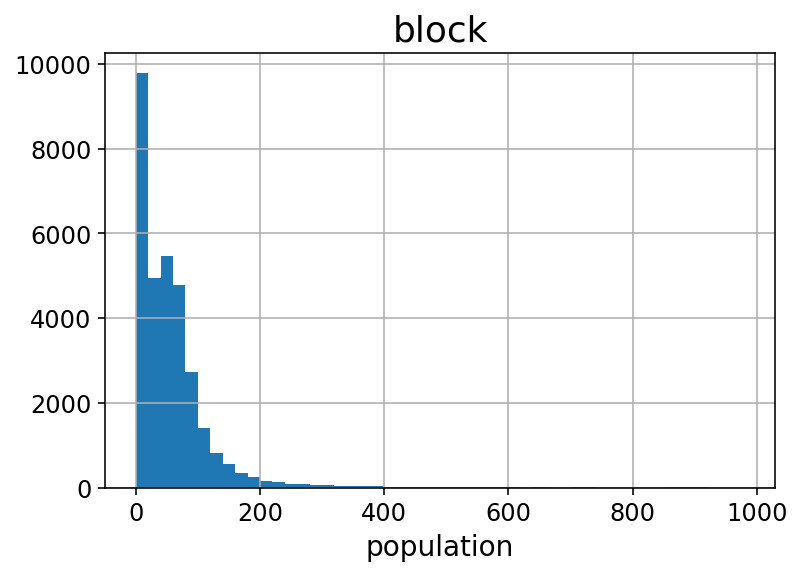

In [200]:
# by block
decennial_p1_2020.population.hist(bins=np.arange(0,1000,20))
print(f"Proportion 0 population: {(decennial_p1_2020.population==0).sum()/decennial_p1_2020.shape[0]:.4f}")
_ = plt.gca().set(title='block',xlabel='population')

Proportion 0 population: 0.0312


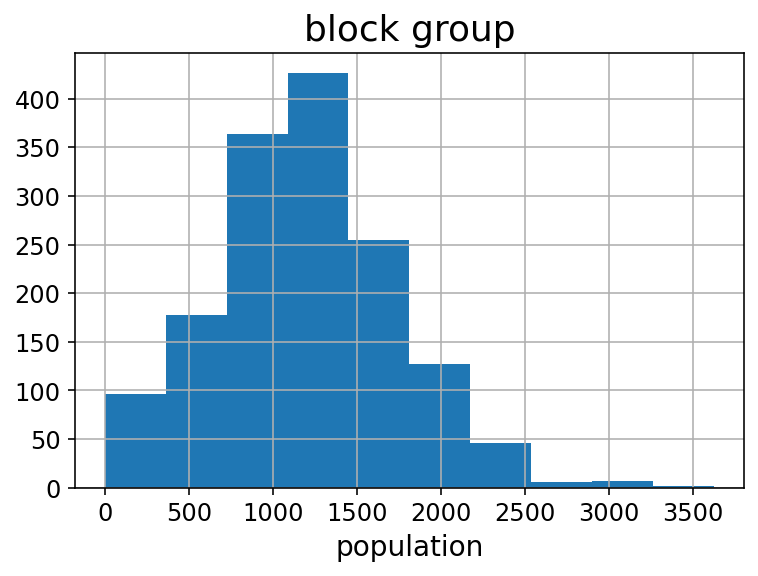

In [201]:
tmp = decennial_p1_2020.assign(block_group = lambda x: x.block_id.astype(int).astype(str).str[:-3]).groupby('block_group').population.sum()
print(f"Proportion 0 population: {(tmp==0).sum()/len(tmp):.4f}")
tmp.hist()
_ = plt.gca().set(title='block group',xlabel='population')

Proportion 0 population: 0.0431


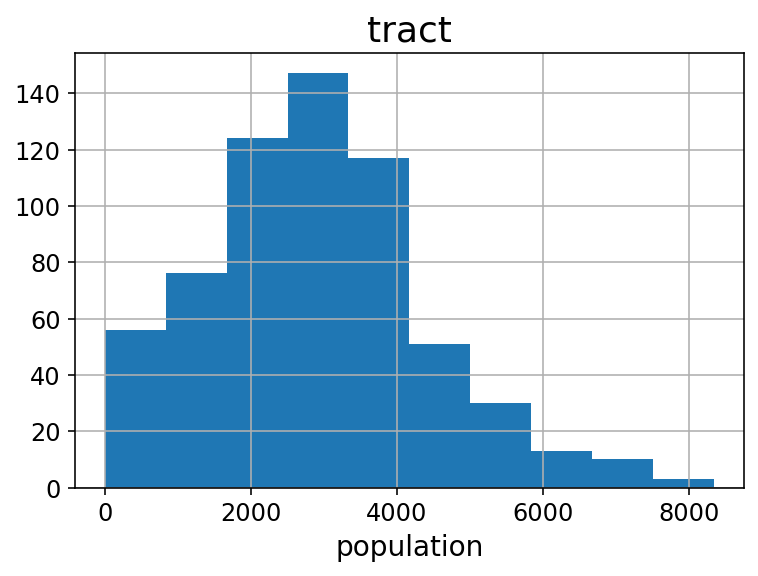

In [202]:
tmp = decennial_p1_2020.assign(tract = lambda x: x.block_id.astype(int).astype(str).str[:-4]).groupby('tract').population.sum()
print(f"Proportion 0 population: {(tmp==0).sum()/len(tmp):.4f}")
tmp.hist()
_ = plt.gca().set(title='tract',xlabel='population')

# Check correspondence with 911 calls data

In [61]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd
import re
import time

pd.options.display.max_rows = 300

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp", 
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
    "longitude",
    "latitude",
]
TYPES_911 = [str, str, float, str, str, str, int, float, float]
# violent
close_proxy = ['ASSAULT','SHOTS','SHOOTING','CUTTING','HOLD UP','WEAP','ROBBERY ARMED','VIOLENT - ARMED','RAPE','STABBED','SHOT']
near_proxy = ['WITH WEAPON','DV','ABUSE','BREAKING AND ENTERING','BREAKING & ENTERING']
expr = re.compile('|'.join(close_proxy))

In [63]:
# use a generator function to select rows we want in chunks rather than loading everything into memory at once
generator = pd.read_csv(
    "calls_for_service_from_jimmy.csv",
    nrows=500000,
    usecols=COLS_911,
    parse_dates=["call_timestamp"],
    chunksize=1e4,
    dtype=dict(zip(COLS_911, TYPES_911)),
)

call = (
    pd.concat(
        [x.loc[lambda x: x.calldescription.str.contains(expr)] for x in generator],
        ignore_index=True,
    )
)

call = gpd.GeoDataFrame(call,geometry=gpd.points_from_xy(call.longitude,call.latitude),crs='epsg:4327')
# Remove some stray data points that are very far away in the same location
call = call.loc[call.longitude > -83.4]

In [80]:
t20 = pd.merge(call.loc[:,['block_id']],decennial_p1_2020,on='block_id',how='outer',indicator=True)

t20._merge.value_counts()

right_only    27213
both          17645
left_only     14962
Name: _merge, dtype: int64

In [79]:
t10 = pd.merge(call.loc[:,['block_id']],decennial_p1_2010,on='block_id',how='outer',indicator=True)

t10._merge.value_counts()

left_only     22344
right_only    10755
both          10263
Name: _merge, dtype: int64

# Relationship files

From the census between 2010 and 2020

Documentation [here](https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2020-census-block-record-layout.html)

In [122]:
# filter to wayne county only
rel = (
    pd.read_csv("/Users/ahakso/Downloads/tab2010_tab2020_st26_mi 2.txt", delimiter="|")
    .loc[lambda x: x.COUNTY_2010 == 163]
    .assign(
        block10=lambda x: x.TRACT_2010.astype(str) + x.BLK_2010.astype(str),
        block20=lambda x: x.TRACT_2020.astype(str) + x.BLK_2020.astype(str),
    )
)

rel.loc[:,['block10','block20']]

,block10,block20
316670,5001001000,5001002000
316671,5001001001,5001002001
316672,5001001002,5001002002
316673,5001001003,5001002003
316674,5001001004,5001002004
...,...,...
354583,9902002,9902001
354584,9902002,9902002
354585,9902003,9902003
354586,9902003,9902004


In [129]:
print(rel.block10.nunique())
print(rel.block20.nunique())

35943
32031


[Text(0.5, 0, 'Blocks per tract in 2010'),
 Text(0, 0.5, 'Tracts in wayne county')]

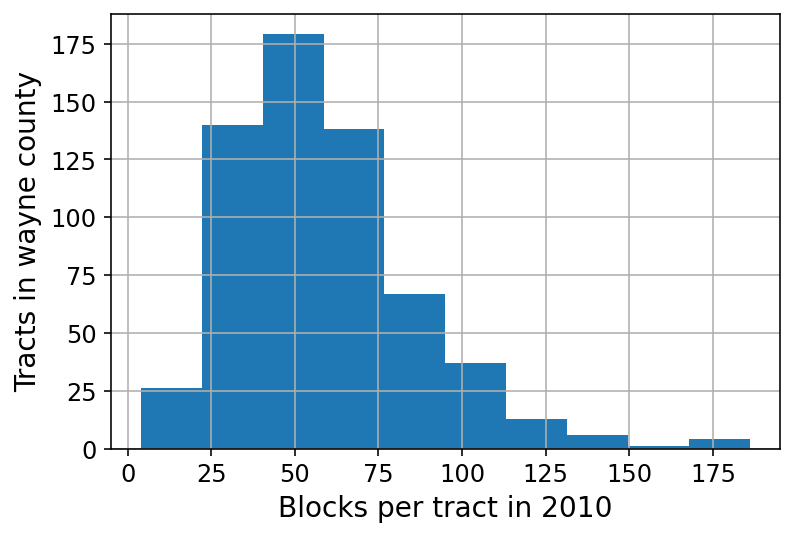

In [140]:
rel.groupby('TRACT_2010').apply(lambda x: x.BLK_2010.nunique()).hist()
plt.gca().set(xlabel='Blocks per tract in 2010',ylabel='Tracts in wayne county')

In [135]:
rel.block10.value_counts()

5454001004    20
5645041015    16
5645011015    15
5646003007    10
5225001006     9
              ..
5390001006     1
5390001005     1
5390001004     1
5390001003     1
9902004        1
Name: block10, Length: 35943, dtype: int64

In [126]:
rel.loc[rel.block10 == rel.block20].shape

(3031, 20)

In [123]:
print(rel.loc[rel.block10 != rel.block20].block20.nunique())
print(rel.loc[rel.BLK_2010 != rel.BLK_2020].block10.nunique())

29361
32837


In [110]:
rel.loc[
    rel.BLK_2010 != rel.BLK_2020,
    [
        "TRACT_2010",
        "TRACT_2020",
        "BLK_2010",
        "BLK_2020",
        "AREALAND_2010",
        "AREALAND_2020",
        "AREALAND_INT",
    ],
]

,TRACT_2010,TRACT_2020,BLK_2010,BLK_2020,AREALAND_2010,AREALAND_2020,AREALAND_INT
316670,500100,500100,1000,2000,35936,35936,35936
316671,500100,500100,1001,2001,19718,19718,19718
316672,500100,500100,1002,2002,19969,19969,19969
316673,500100,500100,1003,2003,19672,19672,19672
316674,500100,500100,1004,2004,19777,19777,19777
...,...,...,...,...,...,...,...
354579,990100,990100,4,3,0,0,0
354580,990100,990100,5,4,0,0,0
354581,990100,990100,6,5,0,0,0
354583,990200,990200,2,1,0,0,0


In [113]:
rel.loc[lambda x: x.BLK_2010==1000]

,STATE_2010,COUNTY_2010,TRACT_2010,BLK_2010,BLKSF_2010,AREALAND_2010,AREAWATER_2010,BLOCK_PART_FLAG_O,STATE_2020,COUNTY_2020,TRACT_2020,BLK_2020,BLKSF_2020,AREALAND_2020,AREAWATER_2020,BLOCK_PART_FLAG_R,AREALAND_INT,AREAWATER_INT
316670,26,163,500100,1000,NaN,35936,0,NaN,26,163,500100,2000,NaN,35936,0,NaN,35936,0
316741,26,163,500200,1000,NaN,19661,0,NaN,26,163,500200,2000,NaN,19661,0,NaN,19661,0
316785,26,163,500300,1000,NaN,21083,0,NaN,26,163,500300,2000,NaN,21083,0,NaN,21083,0
316835,26,163,500400,1000,NaN,19423,0,NaN,26,163,500400,2000,NaN,19423,0,NaN,19423,0
316884,26,163,500500,1000,NaN,10077,0,p,26,163,500500,1000,NaN,5001,0,NaN,5001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354321,26,163,985400,1000,NaN,29317,0,p,26,163,985400,1001,NaN,216292,0,p,213,0
354402,26,163,985500,1000,NaN,0,713356,NaN,26,163,985500,1000,NaN,0,2560276,p,0,713356
354492,26,163,985600,1000,NaN,0,542089,NaN,26,163,985600,1000,NaN,0,1258894,p,0,542089
354513,26,163,985700,1000,NaN,5306,0,NaN,26,163,985700,1000,NaN,65119,0,p,5306,0


In [112]:
rel.BLK_2010.value_counts()

1000    680
1004    660
1002    651
1003    645
1006    640
       ... 
2076      1
2077      1
2078      1
2079      1
6         1
Name: BLK_2010, Length: 458, dtype: int64

[Text(0.5, 0, 'meters on a side'), Text(0, 0.5, 'n blocks in michigan')]

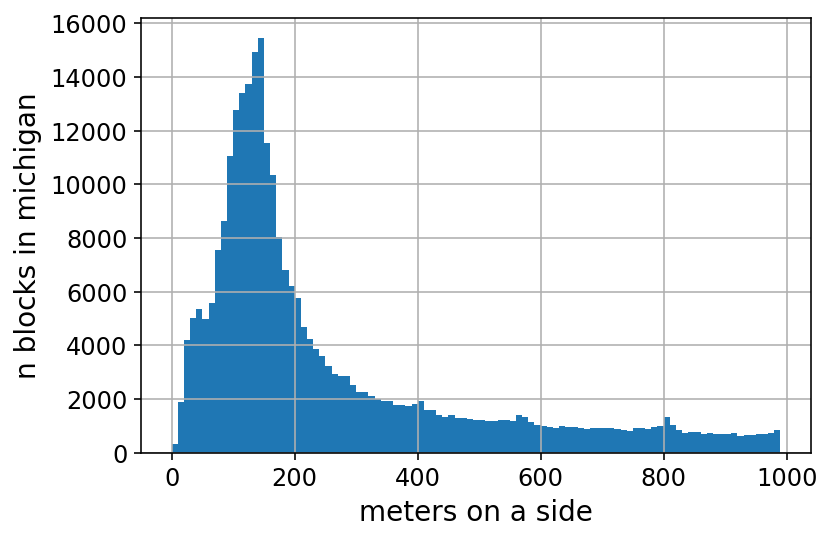

In [103]:
(rel.AREALAND_2010.loc[lambda x: x != 0]**.5).hist(bins=np.arange(0,1000,10))
plt.gca().set(xlabel='meters on a side',ylabel='n blocks in michigan')